В этом блокноте потренируем детектор изображений на основе R-CNN (Region-based Convolutional Network)

In [1]:
import os, cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


Посмотрим, что из себя представляют исходные данные. Фотографии — снимки самолетов в аэропортах. Каждый снимок снабжен аннотацией-разметкой: в соответсвующем csv файле указаны координаты вершин прямоугольника, в котором находится самолет.

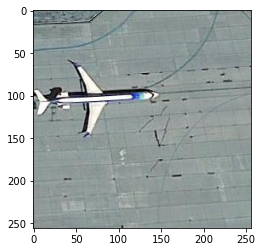

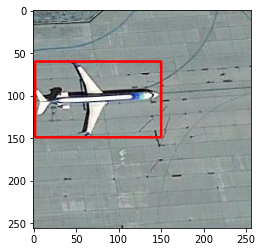

In [2]:
filename = 'airplane_003.jpg'
img = cv2.imread('Pics/' + filename)
df = pd.read_csv('Annotations/' + 'airplane_003.csv')
plt.imshow(img)
for row in df.iterrows():
  x1 = int(row[1][0].split(" ")[0])
  y1 = int(row[1][0].split(" ")[1])
  x2 = int(row[1][0].split(" ")[2])
  y2 = int(row[1][0].split(" ")[3])
  cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

Конечно, для тренировки модели неплохо бы фон отделить от непосредственно самолетов, да и получить побольше различных тренировочных данных. На первом этапе именно этим и займемся.

In [3]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Воспользуемся алгоритмом селективного поиска. Сам алгоритм базируется на графах и методе иерархической группировки похожих участков на снимке. Похожесть включает в себя соответствия по цвету, текстуре, размеру или форме. В графовом представлении вершиной является интенсивность текущего пикселя, ребра соединяют пару соседних пикселей. Вес ребра — это модуль разности интенсивностей пикселей вершин. С помощью графа выделяются фрагменты, которые затем группируются, согласно следующему принципу: ребра между двумя вершинами в одной группе должны иметь меньшие веса, а ребра между двумя вершинами в разных группах должны иметь больший вес. После того, как два наиболее похожих участка сгруппированы, между полученным участком и его соседями вычисляется новое сходство. Процесс группировки наиболее похожих областей повторяется до тех пор, пока все изображение не станет одной областью. В итоге, алгоритм селективного поиска реализуется с помощью детальной сегментации изображения в зависимости от интенсивности пикселей, с использованием метода сегментации на основе графов и выборочного поиска.



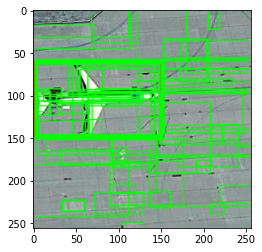

In [4]:
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
img_out = img.copy()
for i, rect in (enumerate(rects)):
  if i < 100:
    x, y, w, h = rect
    cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(img_out)

Реализуем IoU для вычисления меры сходства.

In [5]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

Теперь получим тренировочную выборку

In [6]:
train_images=[]
train_labels=[]
for e, i in enumerate(os.listdir('Annotations')):
    try:
        if i.startswith("airplane"): # Обучаться будем только на картинках, название которых содержит airplane (700 штук)
            filename = i.split(".")[0]+".jpg"
            print(filename)
            image = cv2.imread('Pics/' + filename)
            df = pd.read_csv('Annotations/' + i)
            coordinates = []
            for row in df.iterrows(): # Парсим координаты
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                coordinates.append({"x1": x1,"x2": x2,"y1": y1,"y2": y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            true_counter = 0
            false_counter = 0
            flag = 0
            true_flag = 0
            false_flag = 0
            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for coord in coordinates:
                        x, y, w, h = result # Получаем координаты прямоугольника
                        iou = get_iou(coord,{"x1": x,"x2": x + w,"y1": y,"y2": y + h}) # Сравниваем
                        if true_counter < 30: # С каждой картинки берем не более 30 положительных примеров
                            if iou > 0.8: # Считаем пример положительным, если мера больше, чем ...
                                timage = imout[y: y + h, x: x + w]
                                resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA) # все картинки делаем одинаковыми
                                train_images.append(resized)
                                train_labels.append(1)
                                true_counter += 1
                        else :
                            true_flag = 1 # Набрали достаточное количество положительных примеров
                        if false_counter < 30: # С каждой картинки берем не более 30 отрицательных примеров
                            if iou < 0.2: # Считаем пример отрицательным, если мера меньше, чем ...
                                timage = imout[y: y + h, x: x + w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA) # все картинки делаем одинаковыми
                                train_images.append(resized)
                                train_labels.append(0)
                                false_counter += 1
                        else :
                            false_flag = 1 # Набрали достаточное количество отрицательных примеров
                    if true_flag == 1 and false_flag == 1:
                        print("Nice picture") # Если набрали 30 положительных и 30 отрицательных примеров с одной картинки — заканчиваем
                        flag = 1
    except Exception as e:
        print(e)
        print("error in " + filename)
        continue

airplane_489.jpg
airplane_304.jpg
airplane_462.jpg
airplane_476.jpg
airplane_310.jpg
airplane_338.jpg
Nice picture
airplane_660.jpg
airplane_106.jpg
airplane_112.jpg
airplane_674.jpg
airplane_648.jpg
airplane_099.jpg
airplane_072.jpg
airplane_066.jpg
airplane_700.jpg
airplane_270.jpg
airplane_516.jpg
airplane_502.jpg
airplane_264.jpg
airplane_258.jpg
airplane_259.jpg
airplane_503.jpg
airplane_265.jpg
airplane_271.jpg
airplane_517.jpg
airplane_067.jpg
airplane_073.jpg
airplane_098.jpg
airplane_649.jpg
airplane_113.jpg
airplane_675.jpg
airplane_661.jpg
airplane_107.jpg
airplane_339.jpg
airplane_477.jpg
airplane_311.jpg
airplane_305.jpg
airplane_463.jpg
airplane_488.jpg
airplane_313.jpg
airplane_475.jpg
airplane_461.jpg
airplane_307.jpg
airplane_449.jpg
airplane_688.jpg
airplane_677.jpg
airplane_111.jpg
airplane_105.jpg
airplane_663.jpg
airplane_139.jpg
airplane_065.jpg
airplane_071.jpg
airplane_059.jpg
airplane_298.jpg
airplane_267.jpg
airplane_501.jpg
airplane_515.jpg
airplane_273.jpg
a

Получили тренировочный набор данных. Положительных примеров где-то 1/3

(25103, 224, 224, 3)


4163

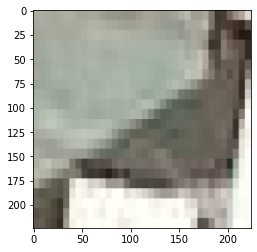

In [7]:
X_new = np.array(train_images)
y_new = np.array(train_labels)
print(X_new.shape)
plt.imshow(X_new[0])
y_new[0]
np.count_nonzero(y_new)

Подключим CNN VGG16

In [8]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights = 'imagenet', include_top = True)

Можно посомтреть на ее архитектуру

In [9]:
for layers in (vggmodel.layers):
    print(layers)

Заморозим первые 15 слоев. Настроим распознавание двух классов. Посмотрим на итоговую обучаемую модель.

In [10]:
for layers in (vggmodel.layers)[:15]:
    layers.trainable = False
X = vggmodel.layers[-2].output
predictions = Dense(2, activation = "softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)
opt = Adam(lr = 0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Подготовим тренировочный и тестовый наборы данных

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1 - Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold = None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y = lenc.fit_transform(y_new)
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size = 0.15)

Проведем аугментацию данных перед обучением

In [12]:
trdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
traindata = trdata.flow(x = X_train, y = y_train)
tsdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
testdata = tsdata.flow(x = X_test, y = y_test)

Проведем обучение

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
early = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 100, verbose = 1, mode = 'auto')
hist = model_final.fit_generator(generator = traindata, steps_per_epoch = 10, epochs = 100, validation_data = testdata, validation_steps = 2, callbacks = [checkpoint, early])

Epoch 1/100
10/10 [==============================] - 110s 11s/step - loss: 1.1858 - accuracy: 0.7844 - val_loss: 0.2021 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 0.20207, saving model to ieeercnn_vgg16_1.h5
Epoch 2/100
10/10 [==============================] - 111s 11s/step - loss: 0.2734 - accuracy: 0.8969 - val_loss: 0.1385 - val_accuracy: 0.9531

Epoch 00002: val_loss improved from 0.20207 to 0.13845, saving model to ieeercnn_vgg16_1.h5
Epoch 3/100
10/10 [==============================] - 108s 11s/step - loss: 0.3015 - accuracy: 0.9156 - val_loss: 0.1084 - val_accuracy: 0.9531

Epoch 00003: val_loss improved from 0.13845 to 0.10842, saving model to ieeercnn_vgg16_1.h5
Epoch 4/100
10/10 [==============================] - 112s 11s/step - loss: 0.1715 - accuracy: 0.9531 - val_loss: 0.7154 - val_accuracy: 0.9219

Epoch 00004: val_loss did not improve from 0.10842
Epoch 5/100
10/10 [==============================] - 107s 11s/step - loss: 0.2677 - accuracy: 0.9187 

16 42849.jpg
27 42848.jpg


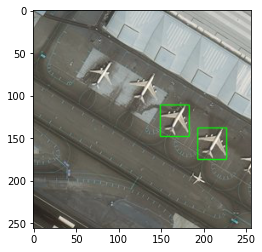

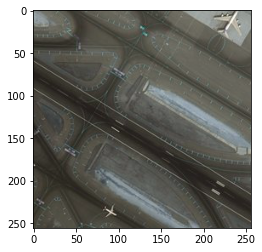

In [16]:
temp = 0
for e,i in enumerate(os.listdir('Annotations')):
    if i.startswith("4"):
        temp += 1
        filename = i.split(".")[0]+".jpg"
        print(e, filename)
        img = cv2.imread('Pics/' + filename)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 10000:
                x,y,w,h = result
                timage = imout[y: y + h,x: x + w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis = 0)
                out= model_final.predict(img)
                if out[0][0] > 0.60:
                    cv2.rectangle(imout, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        if(temp > 1):
            break